In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import json

def load_data(file_name):
    data = {
            "id": [],
            "label": [],
            "prob": [],
            "all_prob": []
    }
    with open(file_name, "r") as file:
        for line in file:
            aux_dict = json.loads(line)
            
            data["id"] += [aux_dict["id"]]
            data["label"] += [aux_dict["result"]["label"]]
            data["prob"] += [aux_dict["result"]["prob"]]
            data["all_prob"] += [aux_dict["result"]["all_prob"]]

    return data

results_adj = load_data("results/minilm/multinli_1.0_dev_mismatched-adj-minilm.jsonl")
results_noun = load_data("results/minilm/multinli_1.0_dev_mismatched-noun-minilm.jsonl")
results_standard = load_data("results/minilm/multinli_1.0_dev_mismatched-standard-minilm.jsonl")
results_char = load_data("results/minilm/multinli_1.0_dev_mismatched-char-minilm.jsonl")
results_verb = load_data("results/minilm/multinli_1.0_dev_mismatched-verb-minilm.jsonl")

In [5]:
results_adverserial_letter = load_data("results/minilm/multinli_1.0_dev_mismatched-adverserial_shuffle_letters-minilm.jsonl")
results_adverserial_tok = load_data("results/minilm/multinli_1.0_dev_mismatched-adverserial_shuffle_tokens_one_neighbour-minilm.jsonl")

In [6]:
import json
import pandas as pd

# data_path = "data/" + "/snli_1.0" + "/snli_1.0_test.jsonl"
data_path = "data/" + "/multinli_1.0" + "/multinli_1.0_dev_mismatched.jsonl"

data = []
limit = 500_000
with open(data_path, "r") as file:
    for _ in range(limit):
        json_obj = file.readline()
        if json_obj != "":
            data += [json.loads(json_obj)]
        else:
            break

data_df = {
    "label": [],
    "sent1": [],
    "sent2": []
}

for datum in data:
    data_df["label"] += [datum["gold_label"]]
    data_df["sent1"] += [datum["sentence1"]] # premise
    data_df["sent2"] += [datum["sentence2"]] # hypothesis

data_df = pd.DataFrame(data_df)
print(data_df.shape)
data_df.head()

gt_labels=data_df["label"].to_numpy()
gt_labels_num = data_df["label"].value_counts().to_dict()

gt_labels_num = dict(sorted(gt_labels_num.items(), key=lambda x:x[0]))

gt_labels_num

(10000, 3)


{'-': 168, 'contradiction': 3240, 'entailment': 3463, 'neutral': 3129}

In [12]:
sum(results_adverserial_letter["label"] == gt_labels)/len(gt_labels)

0.7175

In [7]:
from collections import defaultdict
import numpy as np

def get_labels_number(res_dict):
    labels_model_custom = defaultdict(int)
    for label in res_dict["label"]:
        labels_model_custom[label] += 1
    labels_model_custom = dict(sorted(labels_model_custom.items(), key=lambda x:x[0]))
    print(labels_model_custom)
    return labels_model_custom

results_adj_num = get_labels_number(results_adj)
results_noun_num = get_labels_number(results_noun)
results_standard_num = get_labels_number(results_standard)
results_char_num = get_labels_number(results_char)
results_verb_num = get_labels_number(results_verb)

results_standard_labels = np.asarray(results_standard["label"])
results_adj_labels = np.asarray(results_adj["label"])
results_noun_labels = np.asarray(results_noun["label"])
results_char_labels = np.asarray(results_char["label"])
results_verb_labels = np.asarray(results_verb["label"])


{'contradiction': 2871, 'entailment': 5079, 'neutral': 2050}
{'contradiction': 2756, 'entailment': 5079, 'neutral': 2165}
{'contradiction': 3008, 'entailment': 3709, 'neutral': 3283}
{'contradiction': 567, 'entailment': 9349, 'neutral': 84}
{'contradiction': 2904, 'entailment': 5041, 'neutral': 2055}


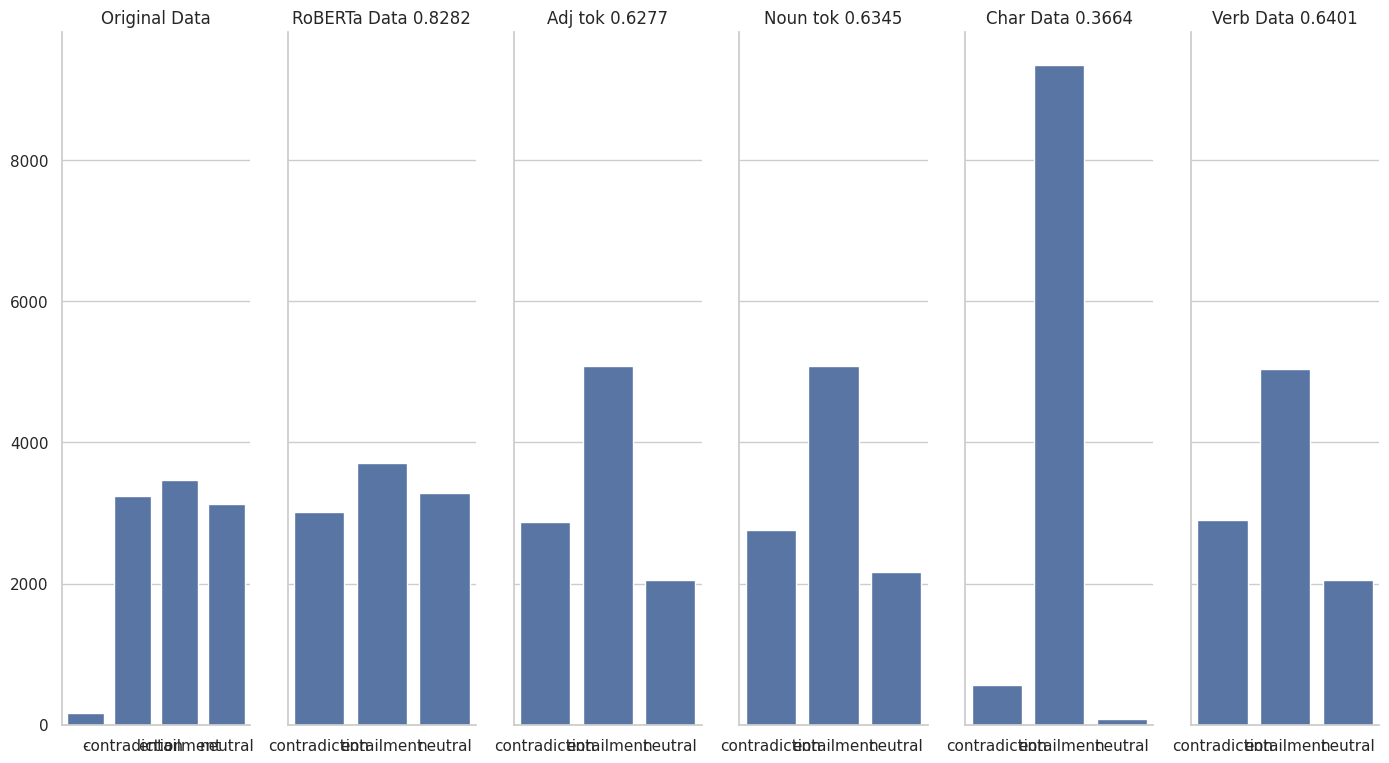

In [6]:
sns.set_theme(style="whitegrid")

def make_bar_plot(result_dict, title, ax):
    sns.barplot(result_dict, ax=ax)
    ax.set_title(title)

fig, axes = plt.subplots(1,6, figsize=(17,9), sharey=True)
make_bar_plot(gt_labels_num, "Original Data", axes[0])
make_bar_plot(results_standard_num, f"RoBERTa Data {sum(results_standard_labels == gt_labels)/len(gt_labels)}", axes[1])
make_bar_plot(results_adj_num, f"Adj tok {sum(results_adj_labels == gt_labels)/len(gt_labels)}", axes[2])
make_bar_plot(results_noun_num, f"Noun tok {sum(results_noun_labels == gt_labels)/len(gt_labels)}", axes[3])
make_bar_plot(results_char_num, f"Char Data {sum(results_char_labels == gt_labels)/len(gt_labels)}", axes[4])
make_bar_plot(results_verb_num, f"Verb Data {sum(results_verb_labels == gt_labels)/len(gt_labels)}", axes[5])
sns.despine()
plt.show()